In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms
import pandas as pd

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=604x403 at 0x205DD3DB0A0>
Размеры (numpy):  (403, 604, 3)
Размеры (torch):  torch.Size([3, 403, 604])


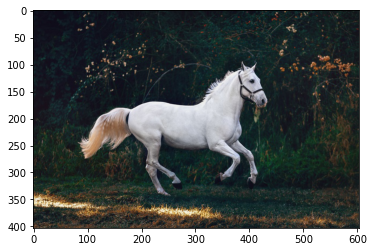

In [58]:
image = Image.open('horse.jpg')
print(image)
plt.imshow(image)
img_array = np.asarray(image)
img_tensor = torchvision.transforms.ToTensor()(image)
print('Размеры (numpy): ', img_array.shape)
print('Размеры (torch): ', img_tensor.shape)


Попробуем  уже обученную сеть на наших изображениях (в качестве примера будем использовать изображения в ультрафиолете, где есть явный перед интесивностей пикселей)  

Рассмотрим модели FCN и DeepLab v3. Данные модели обучилась сегментировать 20+ различных категорий. Модели ожидают 3х-канальное изображение, нормализованное особым образом

In [59]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Сделаем некоторые преобразования над изображением:  
- изменим размер
- обрежем
- преобразуем в тензор 
- нормализуем

In [60]:
import torchvision.transforms as T

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
trf = T.Compose([T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(mean=mean, std=std)])
input_image = trf(image).unsqueeze(0)
input_image.shape

torch.Size([1, 3, 224, 224])

In [61]:
output_image = fcn(input_image)['out']
output_image.shape

torch.Size([1, 21, 224, 224])

In [62]:
output_image = torch.argmax(output_image.squeeze(), dim=0).detach().cpu().numpy()
output_image.shape

(224, 224)

In [63]:
def decode_segmap(image, nc=21):
    labels_colors = np.array([(0,0,0), (128, 0, 0), (0, 128, 0),
                             (128, 128, 0), (0, 0, 128), (128, 0, 128),
                             (0, 128, 128), (128, 128, 128), (64, 0, 0),
                             (192, 0, 0), (64, 128, 0), (192, 128, 0), (64, 0, 128),
                             (192, 0, 128), (64, 128, 128), (192, 128, 128),
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0),
                             (0, 64, 128)])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = labels_colors[l, 0]
        g[idx] = labels_colors[l, 1]
        b[idx] = labels_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis = 2)
    return rgb

In [64]:
rgb = decode_segmap(output_image)

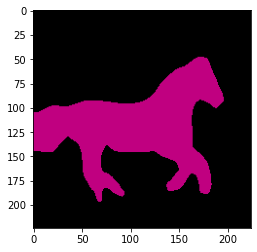

In [65]:
plt.imshow(rgb)

In [70]:
np.unique(rgb)

array([  0, 128, 192], dtype=uint8)